# Gradient Boosting for Cambridge UK Weather Time Series

Gradient boosting models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 48 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

Load most of the required packages.

In [1]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 13.4 MB/s 


In [2]:
import sys
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.preprocessing import StandardScaler

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

%matplotlib inline

env: PYTHONHASHSEED=0




## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in April 2021 and occur every 30 mins.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Shape:
(249916, 23)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249916 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ds                249916 non-null  datetime64[ns]
 1   y                 249916 non-null  float64       
 2   humidity          249916 non-null  float64       
 3   pressure          249916 non-null  float64       
 4   dew.point         249916 non-null  float64       
 5   wind.x            249916 non-null  float64       
 6   wind.y            249916 non-null  float64       
 7   day.sin           249916 non-null  float64       
 8   day.cos           249916 non-null  float64       
 9   year.sin          249916 non-null  float64       
 10  year.cos          249916 non-null  float64       
 11  missing           249916 non-null  int64         
 12  known_inaccuracy  249916 non-null  int64         
 13

,y,humidity,pressure,dew.point,wind.x,wind.y,day.sin,day.cos,year.sin,year.cos,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
count,249916.000000,249916.000000,249916.000000,249916.000000,2.499160e+05,249916.000000,2.499160e+05,2.499160e+05,249916.000000,249916.000000,...,249916.000000,249916.000000,249916.000000,249916.000000,249916.000000,249916.000000,249916.00000,249916.000000,249916.000000,249916.000000
mean,10.186721,78.021093,1014.627225,5.888368,-1.697490e+00,-1.226359,-7.697768e-04,-5.315955e-03,-0.007432,-0.006098,...,0.014661,0.022167,0.001613,0.000236,0.001056,0.027157,0.02871,0.018646,0.003309,0.003309
std,6.523153,17.568631,11.818436,5.153429,4.043233e+00,3.723188,7.070175e-01,7.071785e-01,0.706881,0.707270,...,0.120192,0.147228,0.040124,0.015363,0.032485,0.162541,0.16699,0.135273,0.057430,0.057430
min,-7.000000,20.000000,963.000000,-10.000000,-2.880000e+01,-29.200000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,5.200000,67.000000,1008.000000,2.000000,-3.800000e+00,-3.181981,-7.071068e-01,-7.071068e-01,-0.713759,-0.711514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,10.000000,82.000000,1016.000000,6.000000,-2.121320e-01,0.000000,-4.069232e-14,-1.356244e-12,-0.014955,-0.015851,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,15.000000,92.000000,1023.000000,9.700000,1.530808e-16,0.006161,7.071068e-01,7.071068e-01,0.699402,0.703291,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,37.800000,100.000000,1051.000000,20.900000,2.050610e+01,21.800000,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000



Raw data:


,ds,y,humidity,pressure,dew.point,wind.x,wind.y,day.sin,day.cos,year.sin,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
ds,,,,,,,,,,,,,,,,,,,,,
2008-08-01 00:00:00,2008-08-01 00:00:00,20.0,48.6300,1014.666667,8.055,-0.999378,-0.999378,-4.616835e-12,1.000000,-0.495925,...,0,0,0,0,0,0,1,1,0,0
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,47.3425,1014.642857,7.360,-0.792970,-0.792970,1.305262e-01,0.991445,-0.496237,...,0,0,0,0,0,0,1,1,0,0
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,50.8250,1014.600000,7.775,-0.923953,-0.923953,2.588190e-01,0.965926,-0.496548,...,0,0,0,0,0,0,1,1,0,0
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,44.9500,1014.714286,6.590,-0.934391,-0.934391,3.826834e-01,0.923880,-0.496859,...,0,0,0,0,0,0,1,1,0,0
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,46.6000,1014.333333,7.020,-0.876812,-0.876812,5.000000e-01,0.866025,-0.497170,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-18 22:00:00,2022-09-18 22:00:00,9.2,82.0000,1024.000000,6.300,0.000000,0.000000,-5.000000e-01,0.866025,-0.976507,...,0,0,0,0,0,0,0,0,0,0
2022-09-18 22:30:00,2022-09-18 22:30:00,9.2,81.0000,1024.000000,6.100,0.000000,0.000000,-3.826834e-01,0.923880,-0.976584,...,0,0,0,0,0,0,0,0,0,0
2022-09-18 23:00:00,2022-09-18 23:00:00,9.2,81.0000,1024.000000,6.100,0.000000,0.000000,-2.588190e-01,0.965926,-0.976661,...,0,0,0,0,0,0,0,0,0,0


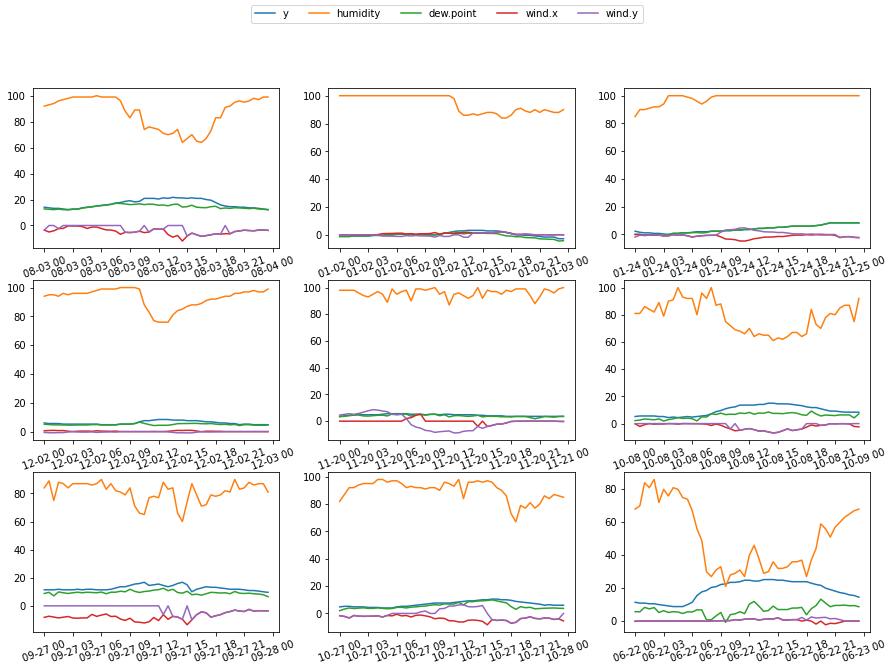

In [3]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated2022.09.20.csv?raw=true"
else:
    data_loc = "../data/CamMetCleanishMissAnnotated2022.09.20.csv"

df = pd.read_csv(data_loc, parse_dates=['ds'])
df.set_index('ds', drop=False, inplace=True)
df_orig = df


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
for column in ['temperature', 'dew.point', 'wind.speed.mean']:
    df[column] /= 10

df['y'] = df['temperature']
    
df = df.loc['2008-08-01 00:00:00':'2022-09-19 00:00:00',]
#df.reset_index(drop=True, inplace=True)  # forget it jake it's SettingWithCopyWarning


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.
wv = df['wind.speed.mean']
wd_rad = df['wind.bearing.mean'] * np.pi / 180  # Convert to radians

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)


# Convert to secs and add sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = 365.2425 * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))


df.drop('temperature',       axis=1, inplace=True)
df.drop('wind.speed.mean',   axis=1, inplace=True)
df.drop('wind.bearing.mean', axis=1, inplace=True)

cols = ['ds', 'y', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y', \
        'day.sin', 'day.cos', 'year.sin', 'year.cos', 'missing', 'known_inaccuracy', \
        'isd_outlier', 'long_run', 'spike', 'cooksd_out', 'isd_3_sigma', \
        'isd_filled', 'hist_average', 'mi_filled', 'mi_spike_interp', 'lin_interp']
df = df.loc[:, cols]
#df.reset_index(drop=True, inplace=True)  # forget it jake it's SettingWithCopyWarning



# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped2022.09.20.csv"
    df.to_csv(data_loc)


print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, cols):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    assert len(data) == 9

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
        for col in cols:
            axs[i].plot(data[i]['ds'], data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


num_plots = 9
days = df.ds.dt.date.sample(n = num_plots).sort_values()
p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]
cols   = ['y', 'humidity', 'dew.point', 'wind.x', 'wind.y']  # 'pressure',    

plot_examples(p_data, cols)


---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

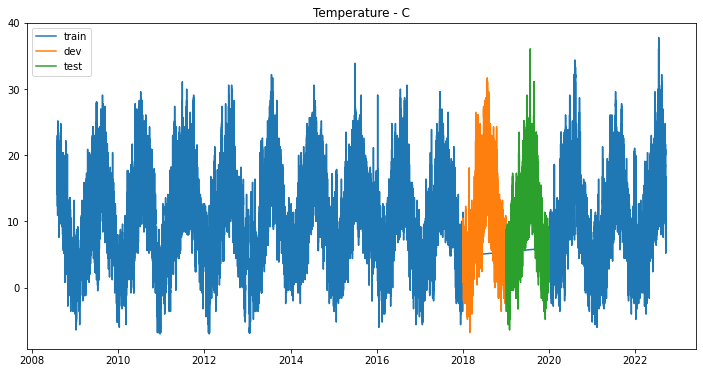

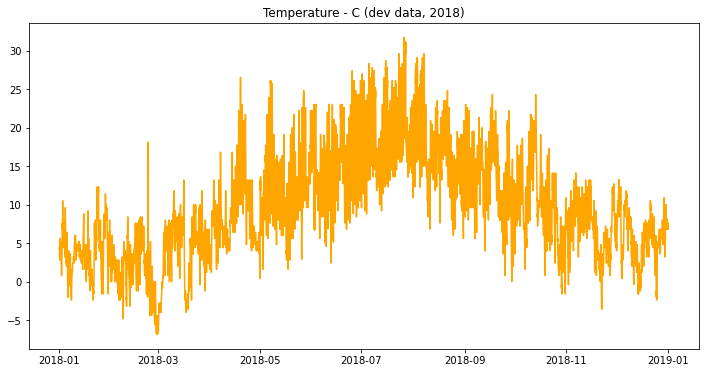

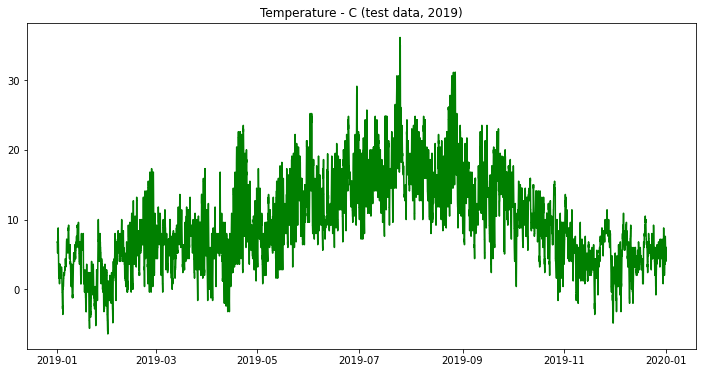

df.drop shape:  (249916, 22)
train shape:    (214696, 22)
valid shape:    (17653, 22)
test shape:     (17567, 22)


In [4]:
# keep_cols = ['ds', 'y', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y', \
#              'day.sin', 'day.cos', 'year.sin', 'year.cos', 'missing', 'known_inaccuracy', \
#              'isd_outlier', 'long_run', 'spike', 'cooksd_out', 'isd_3_sigma', \
#              'isd_filled', 'hist_average', 'mi_filled', 'mi_spike_interp', 'lin_interp']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (12, 6))
plt.plot(train_df.ds, train_df.y)
plt.plot(valid_df.ds, valid_df.y)
plt.plot(test_df.ds,  test_df.y)
plt.title('Temperature - C')
plt.legend(['train', 'dev', 'test'])
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - C (test data, 2019)')
plt.show()


del_cols = ['ds', 'year']  #, 'wind.speed.mean', 'wind.bearing.mean']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(del_cols, axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)


---

### Normalise data

Features do not need to be scaled for gradient boosting methods. Nonetheless, it can often be a
useful sanity check.

The [violin plot](https://en.wikipedia.org/wiki/Violin_plot) shows the distribution of features.

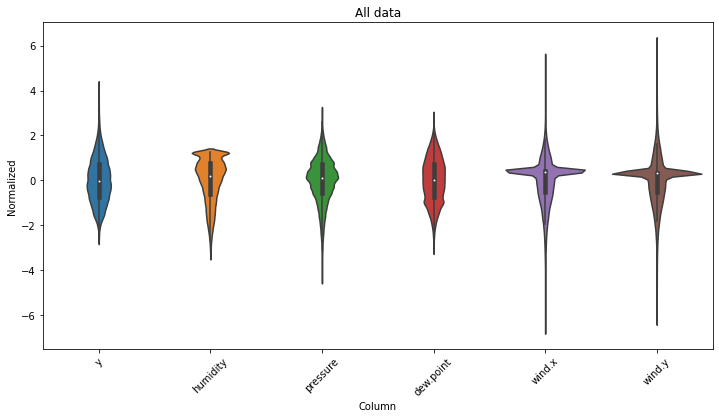

In [5]:
def inv_transform(scaler, data, colName, colNames):
    """An inverse scaler for use in model validation section

    For later use in plot_forecasts, plot_horizon_metrics and check_residuals
    
    See https://stackoverflow.com/a/62170887/100129"""

    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    
    return dummy[colName].values


cols = ['y', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
train_df_norm = train_df.loc[:, cols]
scaler = StandardScaler()
scaler.fit(train_df_norm)

train_df_norm = scaler.transform(train_df_norm)
# valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
# test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

#df_std = scaler.transform(df)
df_std = pd.DataFrame(train_df_norm)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(cols, rotation = 45)
ax.set_title('All data');

Some features have long tails but there are no glaring errors.


---

## Gradient Boosted Model Building

Gradient boosted models intro ...

Gradient boosted models for time series ...

I had hoped to use the [skforecast](https://joaquinamatrodrigo.github.io/skforecast/) time series framework.  Unfortunately, as of the current version (0.5.0) it does not support forecasts with multivariate data.  Perhaps [sktime](https://www.sktime.org/en/stable/index.html) will be a good alternative ...

The following are a few points I consider when building these gradient boosted models.

Forecast horizons:
  * next 24 hours - 48 steps ahead

Metrics:
 * mse - mean squared error
   * mse used for loss function to avoid potential problems with infinite values from the square root function
   * rmse - root mean squared error is used for comparison with baselines
   * Huber loss may be worth exploring in the future if outliers remain an issue
 * mae - median absolute error
 * mape - mean absolute percentage error 
   * Not used - mape fails when values, like temperature, become zero



Parameters to consider optimising:
 * lags
 * exogenous variables
   * time component representations
     * sinusoidal
     * [periodic spline features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#periodic-spline-features) ??
 * hyperparameters
```
param_grid = {
    'n_estimators':  [100, 500],
    'max_depth':     [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
```


Models considered:
 1. xgboost
   * ...
   
 2. lightgbm
   * ...

 3. ...?


---


...

**TODO** Perhaps there is something salvagable here?

Specify some utility functions for running, plotting and summarising results:

 * `plot_history`
 * `plot_forecasts`
 * `plot_horizon_metrics`
 * `check_residuals`
 
For running multiple models with specified parameters:
  * `random_search_params` - multiple parameters eg. lags and feature_maps
  * `sweep_param` - single parameter eg. lags

and summarising performance of multiple models:
  * `rank_models`
  * `get_best_models`

Note that I don't use the `random_search_params` function all that much in this notebook because I prefer the scikit-optimize approach outlined in the code cell following this one.

In [6]:
def compile_fit_validate(models, model_name, params, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    model = models[model_name]['model']
    train_data = models[model_name]['train']
    valid_data = models[model_name]['valid']
    
    model.summary()

    # opt = Adam(learning_rate = 0.001)
    opt = Adam(models[model_name]['lrf'].best_lr)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae']) 
       
    es = EarlyStopping(monitor = 'val_loss', 
                       mode = 'min', 
                       verbose = 1, 
                       patience = 10,
                       restore_best_weights = True)  # return best model, not last model
    lr = ReduceLROnPlateau(monitor = 'val_loss', 
                           factor = 0.2, 
                           patience = 5, 
                           min_lr = 0.00001)
   
    h = model.fit(train_data, validation_data = valid_data,
                  epochs = params['epochs'], verbose = verbose, callbacks = [es, lr])
    
    return h

    
def plot_history(h, name, epochs = 10):
    fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
    axs = axs.ravel()

    if 'fm_' in name:
      name = name.replace('fm_', 'fm\n')

    axs[0].plot(h.history['loss'])
    axs[0].plot(h.history['val_loss'])
    axs[0].set_title(name + '\nloss')
    axs[0].set_xticklabels(range(1, epochs + 1))
    axs[0].set_xticks(range(0, epochs))
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'valid'], loc = 'upper right')

    axs[1].plot(h.history['mae'])
    axs[1].plot(h.history['val_mae'])
    axs[1].set_title(name + '\nmae')
    axs[1].set_xticks(range(0, epochs))
    axs[1].set_xticklabels(range(1, epochs + 1))
    axs[1].set_ylabel('mae')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    return None

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tepoch: {4:d}"
    print(txt.format(name, "train", min_loss,     mae,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, argmin_val_loss + 1))
    print()

    return None


def plot_forecasts(models, model_name, dataset = 'valid', subplots = 3):
    """Plot example forecasts with observations and lagged temperatures.

       First row shows near zero rmse forecasts.
       Second row shows most positive rmse forecasts.
       Third row shows most negative rmse forecasts.
    """

    # get model etc
    model   = models[model_name]['model']
    params  = models[model_name]['params']
    horizon = params['steps_ahead']
    lags    = params['lags']

    assert horizon >= 12
    assert subplots in [3, 4, 5]

    # get data
    if dataset == 'test':
      data = models[model_name]['test']
    elif dataset == 'train':
      data = models[model_name]['train']
    elif dataset == 'valid':
      data = models[model_name]['valid']
    else:
      print("Unknown dataset:", dataset)
      return None

    # make forecast
    preds = model.predict(data)
    preds = preds.reshape((preds.shape[0], preds.shape[1]))
    preds = preds[::horizon]

    obs   = np.concatenate([y for _, y in data], axis = 0)
    long_obs = obs.reshape((obs.shape[0], obs.shape[1]))
    long_obs = long_obs[::horizon]

    res = long_obs - preds  # res for residual
    res_sign = np.sign(-res.mean(axis = 1))

    err = (long_obs - preds) ** 2  # err for error
    err_row_means = err.mean(axis = 1)
    rmse_rows = res_sign * np.sqrt(err_row_means)

    # choose forecasts
    neg_rmse = np.argsort(rmse_rows)[:subplots]
    pos_rmse = np.argsort(-rmse_rows)[:subplots]
    nz_rmse  = np.argsort(np.abs(rmse_rows))[:subplots]  # nz near zero

    plot_idx = np.concatenate((nz_rmse, pos_rmse, neg_rmse))

    # plot forecasts
    fig, axs = plt.subplots(3, subplots, sharex = True, sharey = True, figsize = (15, 10))
    axs = axs.ravel()

    for i in range(3 * subplots):
      lagged_obs = get_lagged_obs(long_obs, plot_idx[i] - 1, lags)
      axs[i].plot(range(-lags + 1, 1),
                  inv_transform(scaler, lagged_obs, 'y', models['datasets']['train'].columns),
                  'blue',
                  label='lagged observations')
      axs[i].plot(range(1, horizon + 1), 
                  inv_transform(scaler, preds[plot_idx[i]],    'y', models['datasets']['train'].columns),
                  'orange',
                  label='forecast')
      axs[i].plot(range(0, horizon), 
                  inv_transform(scaler, long_obs[plot_idx[i]], 'y', models['datasets']['train'].columns),
                  'green',
                  label='observations')
      sub_title = "{0:d} {1:.4f}".format(plot_idx[i], rmse_rows[plot_idx[i]])
      axs[i].title.set_text(sub_title)
    
    fig.suptitle(model_name + " " + dataset + "\nperiod idx, signed rmse")
    fig.text(0.5, 0.04, 'forecast horizon - half hour steps', ha='center')
    fig.text(0.04, 0.5, 'Temperature - $^\circ$C', va='center', rotation='vertical')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show();


def get_lagged_obs(long_obs, plot_idx, lags):
    if long_obs[plot_idx].size < lags:
      lagged_obs = np.flip(long_obs[plot_idx])
    else:
      lagged_obs = long_obs[plot_idx]

    while lagged_obs.size < lags:
      plot_idx -= 1
      lagged_obs = np.concatenate([lagged_obs, np.flip(long_obs[plot_idx])])

    if long_obs[plot_idx].size < lags:
      lagged_obs = np.flip(lagged_obs)

    return lagged_obs[-lags:]


def plot_horizon_metrics(models, model_name, dataset = 'valid'):

    # get model etc
    model   = models[model_name]['model']
    params  = models[model_name]['params']
    horizon = params['steps_ahead']

    assert horizon >= 12

    # get data
    if dataset == 'test':
      data = models[model_name]['test']
    elif dataset == 'train':
      data = models[model_name]['train']
    elif dataset == 'valid':
      data = models[model_name]['valid']
    else:
      print("Unknown dataset:", dataset)
      return None

    # make forecast
    if params['model_type'] in ['encdec', 'transed']:
      obs, preds = predict_encoder_decoder_sequence(models, params, dataset)
    else:
      preds = model.predict(data)
      obs   = np.concatenate([y for _, y in data], axis = 0)

    if len(obs.shape) == 3 and len(preds.shape) == 3:
      # multi-step, multi-feature output
      preds = preds[:, :, 0:1]
      preds = preds.reshape((preds.shape[0], preds.shape[1]))
      obs = obs[:, :, 0:1]
      obs = obs.reshape((obs.shape[0], obs.shape[1]))
    elif len(obs.shape) == 3 and len(preds.shape) == 2:
      obs = obs.reshape((obs.shape[0], obs.shape[1]))

    assert preds.shape == obs.shape

    # calculate metrics
    rmse_h, mae_h = np.zeros(horizon), np.zeros(horizon)

    for i in range(horizon):
      t_obs   = inv_transform(scaler, obs[:, i],   'y', models['datasets']['train'].columns)
      t_preds = inv_transform(scaler, preds[:, i], 'y', models['datasets']['train'].columns)
      rmse_h[i] = rmse(t_obs, t_preds)
      mae_h[i]  = np.median(np.abs(t_obs - t_preds))  # for comparison with baselines
      #mae_h[i]  = mae(t_obs,  t_preds)

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(model_name + " " + dataset)
    axs = axs.ravel()

    mean_val_lab = model_name + ' mean value'
    axs[0].plot(range(1, horizon+1), rmse_h, label=model_name)
    if dataset == 'test':
      var_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23, 1.31, 1.38,
       1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77, 1.81, 1.85, 1.89, 1.92,
       1.96, 1.99, 2.02, 2.05, 2.08, 2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22,
       2.24, 2.26, 2.28, 2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 ,
       2.42, 2.43, 2.44, 2.45])
      axs[0].plot(range(1, horizon+1), var_rmse, label='VAR')
    else:
      axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon, color='yellow', linestyles='dotted', label=mean_val_lab)
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")

    axs[1].plot(range(1, horizon+1), mae_h, label=model_name)
    if dataset == 'test':
      var_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05, 1.12, 1.18,
       1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 , 1.53, 1.56, 1.59, 1.62,
       1.64, 1.66, 1.68, 1.7 , 1.72, 1.73, 1.75, 1.76, 1.77, 1.78, 1.8 ,
       1.81, 1.82, 1.83, 1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87,
       1.88, 1.88, 1.89, 1.89])
      axs[1].plot(range(1, horizon+1), var_mae, label='VAR')
    else:
      axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon, color='yellow', linestyles='dotted', label=mean_val_lab)
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


def plot_obs_preds(obs, preds, title):
    plt.figure(figsize = (12, 8))
    plt.subplot(3, 1, 1)
    plt.scatter(x = obs, y = preds)
    y_lim = plt.ylim()
    x_lim = plt.xlim()
    plt.plot(x_lim, y_lim, 'k-', color = 'grey')
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title(title)


def plot_residuals(obs, preds, title):
    plt.subplot(3, 1, 2)
    plt.scatter(x = range(len(obs)), y = (obs - preds))
    plt.axhline(y = 0, color = 'grey')
    plt.xlabel('Position')
    plt.ylabel('Residuals')
    plt.title(title)


def plot_residuals_dist(obs, preds, title):
    data = obs - preds
    plt.subplot(3, 1, 3)
    pd.Series(data).plot(kind = 'density')
    plt.axvline(x = 0, color = 'grey')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def check_residuals(models, model_name, dataset = 'valid'):
    """Plot observations against predictions, residuals and residual distribution
    
    Warning: The full training set will take approx. 5 mins to plot"""

    assert dataset in ['test', 'valid']

    model = models[model_name]
    data  = model[dataset]

    if model['params']['model_type'] in ['encdec', 'transed']:
      obs, preds = predict_encoder_decoder_sequence(models, 
                                                    models[model_name]['params'],
                                                    dataset)
    else:
      preds = model['model'].predict(data)
      obs   = np.concatenate([y for _, y in data], axis = 0)

    # reshape obs & preds
    label_len = obs.shape[0]
    preds_len = len(preds)
    # print("labels:", label_len)
    # print("preds:",  preds_len)
    # print("preds:",  preds.shape)
    # print("obs:",    obs.shape)
    assert label_len == preds_len

    # print("obs[0]:", obs.shape[0])
    # print("obs[1]:", obs.shape[1])
    preds_long = preds.reshape((obs.shape[0] * obs.shape[1]))
    obs_long   = obs.reshape((obs.shape[0] * obs.shape[1]))

    mse_long = mse(obs_long, preds_long)  # Need to treat 4 step ahead rmse & mae properly
    mae_long = mae(obs_long, preds_long)
    print("mse ", model_name, ": ",  mse_long, sep = '')
    print("mae ", model_name, ":  ", mae_long, sep = '')

    # inverse transform using train mean & sd
    t_preds = inv_transform(scaler, preds_long, 'y', train_df.columns)
    t_obs   = inv_transform(scaler, obs_long,   'y', train_df.columns)

    t_rmse = rmse(t_obs, t_preds)  # Need to treat 4 step ahead rmse & mae properly
    t_mae  =  mae(t_obs, t_preds)
    print("t rmse ", model_name, ": ",  t_rmse, sep = '')
    print("t mae ",  model_name, ":  ", t_mae,  sep = '')

    title = 'Inverse transformed data\n' + model_name
    plot_obs_preds(t_obs, t_preds, title)
    plot_residuals(t_obs, t_preds, title)
    plot_residuals_dist(t_obs, t_preds, title)
    print("\n\n")


def rmse(obs, preds):
    return np.sqrt(np.mean((obs - preds) ** 2))


def mse(obs, preds):
    return np.mean((obs - preds) ** 2)


def mae(obs, preds):
    "mean absolute error - equivalent to the keras loss function"
    return np.mean(np.abs(obs - preds))  # keras loss
    # return np.median(np.abs(obs - preds))  # earlier baselines


def predict_encoder_decoder_sequence(models, params, dataset = 'valid', samples = None):
    """Make predictions for encoder decoder models 

    Iterates through all the batches in the dataset

    Args:
      models     (dict):            all models
      params     (dict):            parameters of model of interest
      dataset    (str, optional):   test, train or validate dataset
      samples    (int, optional):   number of regularly spaced samples to run from dataset

    Returns:
      obs        (pd.DataFrame)
      preds      (pd.DataFrame)

    Notes: ...
    """

    assert params['model_type'] in ['encdec', 'transed']

    model_name = get_model_name(models, params)
    preds_name = dataset + '_preds'
    obs_name   = dataset + '_obs'

    # get models
    infenc = models[model_name]['enc_model']
    infdec = models[model_name]['dec_model']
    infmod = infdec = models[model_name]['model']

    # get data
    if dataset == 'test':
      data = models[model_name]['test']
    elif dataset == 'train':
      data = models[model_name]['train']
    elif dataset == 'valid':
      data = models[model_name]['valid']
    else:
      print("Unknown dataset:", dataset)
      return None

    # if preds_name in models[model_name] and obs_name in models[model_name]:
    #   return models[model_name][obs_name], models[model_name][preds_name]

    # obs = np.concatenate([y for _, y in data], axis = 0)

    # return obs and preds instead?
    # mse_  = list()
    # mae_  = list()
    obs   = list()
    preds = list()

    # get predictions
    i = 0
    interval = 1
    if samples != None:
      batches  = data.cardinality().numpy()
      interval = batches // samples

    for batch in data:
      i += 1

      if i % interval != 0:
        continue

      #if i >= data.cardinality().numpy():
      #  continue
      
      past = batch[0][0]
      obs_ = batch[1].numpy()
      obs_ = obs_.squeeze()
      obs.append(obs_)

      if params['model_type'] == 'encdec':
          preds_ = predict_sequence(infenc, infdec, past, params)
      elif params['model_type'] == 'transed':
          # preds_ = predict_sequence_transformer(infenc, infdec, past, params)
          preds_ = predict_sequence_transformer(infenc, infmod, past, params)
      preds.append(preds_)

      # plt.plot(range(-params['lags'], 0),    past[0, :, 0])
      # plt.plot(range(params['steps_ahead']), obs_)
      # plt.plot(range(params['steps_ahead']), preds_)
      # plt.show()

      # summarise predictions
      # mse_.append(mse(obs_, preds_))
      # mae_.append(mae(obs_, preds_))
    
    # print("mse:", np.mean(mse_))
    # print("mae:", np.mean(mae_))

    preds = np.concatenate(preds, axis=0)
    obs   = np.concatenate(obs,   axis=0)
    models[model_name][preds_name] = preds
    models[model_name][obs_name]   = obs

    return obs, preds

def compute_mask(inputs, mask = None):
    '''compute padding mask - currently unused'''
    # return tf.math.not_equal(inputs, 0)
    return tf.math.not_equal(inputs, tf.constant(-np.inf))


def predict_sequence_transformer(infenc, infmod, source, params):
    """Generate target given source sequence

    Operates on batches of data

    Args:
      infenc    (Keras model):      inference encoder model
      infmod    (Keras model):      inference model
      source    (Keras data batch): input data
      params    (dict):             parameters of model of interest

    Returns:
      output    (pd.DataFrame):    output target sequence

    Notes: based on  
           https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/
    """

    bs = source.shape[0]
    n_steps = params['steps_ahead']

    # encode
    #state = infenc.predict(source)  # Not used!?
    # start of sequence input
    # print("source:", source.shape)
    #source_len = source.shape[1] - 1
    target_seq = source[:, -n_steps:, 0]  #  working :-)
    target_seq = np.array(target_seq).reshape(bs, n_steps, 1)  # working :-)
    #target_seq = source[:, -1, 0]  #  NEXT try this?
    #target_seq = np.array(target_seq).reshape(bs, 1, 1)
    #target_seq = np.array([-np.inf] * bs * n_steps).reshape(bs, n_steps, 1) # was terrible
    #for i in range(bs):
    #  target_seq[i, 0, 0] = source[i, -1, 0]
    #target_seq = source[:, -1, 0]  #  terrible!
    #target_seq = np.array(target_seq).reshape(bs, 1, 1)  # terrible!
    # target_seq = source[:, :, 0]
    # target_seq = np.array([source[i][source_len][0] for i in range(bs)]).reshape(bs, n_steps, 1)
    # target_seq = np.array([[-np.inf] * n_steps for i in range(bs)]).reshape(bs, n_steps, 1)
    # target_seq = np.array([[False] * n_steps for i in range(bs)]).reshape(bs, n_steps, 1)
    # target_seq = np.array([source[i][source_len - n_steps:source_len][0] for i in range(bs)]).reshape(bs, n_steps, 1)
    #target_seq = np.array([source[i][source_len][0] for i in range(bs)]).reshape(bs, 1, 1)  # encdec

    # collect predictions
    output = list()

    # print("source:", source.shape)
    # print("target_seq:", target_seq.shape)
   
    for t in range(1):
      # print("source:", source.shape)
      #print("target_seq:", target_seq.shape)
      # yhat, h, c = infmod.predict([target_seq] + state)  # encdec
      # yhat = infmod.predict([target_seq, state])  # transed ([decoder_inputs, encoded_seq_inputs])
      #padding_mask = compute_mask(target_seq)
      #yhat = infmod([state, target_seq], training = False, mask = padding_mask)  # transed - runs but don't think masking is working
      # yhat = infmod.predict([np.array(source), np.array(target_seq)])
      # yhat = infmod.predict([source, target_seq])  # transformer - working :-)
      yhat = infmod([source, target_seq], training = False, mask = None)  # new working - transformer
      #print("yhat:", yhat.shape)
      #if t < 5:
      #  print("t:", t)
      #  print("target_seq[0, :, 0]:", target_seq[0, :, 0])
      #  print("yhat[0, :, 0]:", yhat[0, :, 0])
      #  #print("padding_mask[0, :, 0]:", padding_mask[0, :, 0])
      #else:
      #  foobar()
      # store prediction
      # output.append(yhat[:, 0, 0])   # store 1st prediction
      #output.append(yhat[:, t, 0])     # store tth prediction  - getting better
      #output.append(yhat[:, -1, 0])  # store last prediction - working :-)
      output = yhat
      # update state
      # state = [h, c]  # encdec
      # update target sequence
      # target_seq = yhat  # encdec
      # target_seq = np.append(target_seq, yhat)
      #target_seq = yhat[:, -1, 0].reshape(bs, 1, 1)  # terrible!
      #target_seq = target_seq[:, 1:, 0].reshape(bs, n_steps-1, 1)  # working :-)
      # print("target_seq:", target_seq.shape)
      #target_seq = np.append(target_seq, yhat[:, n_steps-1, 0]).reshape(bs, n_steps, 1)  # not working :-(
      #target_seq = np.concatenate([target_seq, yhat[:, t, 0, None, None]], axis=1)  # .reshape(bs, t+2, 1)  # working :-)
      #target_seq = np.concatenate([target_seq, yhat[:, -1, 0, None, None]], axis=1)
      #target_seq = np.insert(target_seq, t, yhat[:, -1, 0, None, None], axis=1)
      #for i in range(bs):
      #  target_seq[i, t, 0] = yhat[i, t, 0]  # getting better
      # target_seq = np.array([target_seq[i, n_steps, 0] = yhat[i, n_steps-1, 0] for i in bs]).reshape(bs, n_steps, 1)
      #for i in range(bs):
      #  target_seq = np.concatenate(target_seq[i, n_steps-2, 0], yhat[i, n_steps-1, 0])
      #target_seq = np.vstack([target_seq[:, :, 0], yhat[:, n_steps-1, 0]])

    #return np.array(output).transpose()
    return output


def predict_sequence(infenc, infdec, source, params):
    """Generate target given source sequence

    Operates on batches of data

    Args:
      infenc    (Keras model):      inference encoder model
      infdec    (Keras model):      inference decoder model
      source    (Keras data batch): input data
      params    (dict):             parameters of model of interest

    Returns:
      output    (pd.DataFrame):    output target sequence

    Notes: based on  
           https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/
    """

    bs = source.shape[0]
    n_steps = params['steps_ahead']

    # encode
    state = infenc.predict(source)
    # start of sequence input
    source_len = source.shape[1] - 1
    target_seq = np.array([source[i][source_len][0] for i in range(bs)]).reshape(bs, 1, 1)  # encdec
    # collect predictions
    output = list()
   
    for t in range(n_steps):
      # next prediction
      yhat, h, c = infdec.predict([target_seq] + state)  # encdec
      # store prediction
      output.append(yhat[:, 0, 0])
      # update state
      state = [h, c]
      # update target sequence
      target_seq = yhat

    return np.array(output).transpose()


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns = dictionary.keys())


def random_search_params(models, params, sweep_values, limit = 5):
    sweep_params = list(sweep_values.keys())
    assert len(sweep_params) > 1

    i = 0
    model_names = []
    sweep_df   = expand_grid(sweep_values)
    sweep_rows = sweep_df.sample(n = limit)

    for sweep_row in sweep_rows.itertuples():
      i += 1
      print("%d of %d" %(i, limit))
      print(sweep_row)
      for idx in sweep_params:
        params[idx] = getattr(sweep_row, idx)

      model_name = get_model_name(models, params)
      model_names.append(model_name)
      models[model_name] = {}
      models[model_name]['params'] = params

      ds_train, ds_valid, ds_test = make_datasets(models, params)
      models[model_name]['train'] = ds_train
      models[model_name]['valid'] = ds_valid
      models[model_name]['test']  = ds_test

      models[model_name]['model'] = get_model(models, params)
      models[model_name]['lrf']   = run_lrf(models, params)
      models[model_name]['history'] = run_model(models, params)

    summarise_history(models, model_names)

    return [models, model_names]


def sweep_param(models, params, sweep_values, verbose=False):
    sweep_params = list(sweep_values.keys())
    sweep_param  = sweep_params[0]
    assert len(sweep_params) == 1
    assert len(sweep_values[sweep_param]) >= 1

    model_names = []

    for sweep_value in sweep_values[sweep_param]:
      # params_copy = {key: value[:] for key, value in params.items()}
      params_copy = {key: value for key, value in params.items()}
      params_copy[sweep_param] = sweep_value

      if verbose == True:
        print(sweep_param, ":", sweep_value)

      model_name = get_model_name(models, params_copy)
      model_names.append(model_name)
      models[model_name] = {}
      models[model_name]['params'] = params_copy

      ds_train, ds_valid, ds_test = make_datasets(models, params_copy)
      models[model_name]['train'] = ds_train
      models[model_name]['valid'] = ds_valid
      models[model_name]['test']  = ds_test

      models[model_name]['model']   = get_model(models, params_copy)
      models[model_name]['lrf']     = run_lrf(models,   params_copy)
      models[model_name]['history'] = run_model(models, params_copy)

    summarise_history(models, model_names)

    return [models, model_names]


def check_fit(h, metric, fit_type, ignore = 1):
    badfit = 0

    h_train = h.history[metric]
    h_valid = h.history['val_' + metric]
    h_len = len(np.array(h_train))

    for i in range(ignore, h_len):
      # Disabling underfitting check for now
      # if ( fit_type == 'over'  and h_valid[i] < h_train[i] ) or \
      #    ( fit_type == 'under' and h_valid[i] > h_train[ignore] ):
      if ( fit_type == 'over'  and h_valid[i] < h_train[i] ):
        badfit += 1

    return round(badfit * 100 / (h_len - ignore), 2)


def get_history_stats(h, metric, ignore = 0):
    stats = {}
    
    stats['mean'] = np.mean(np.array(h.history[metric]))
    stats['std']  = np.std(np.array(h.history[metric]))

    h_argmin = np.argmin(np.array(h.history[metric]))
    h_argmax = np.argmax(np.array(h.history[metric]))
    stats['min'] = h.history[metric][h_argmin]
    stats['max'] = h.history[metric][h_argmax]
    stats['argmin'] = h_argmin

    h_len = len(np.array(h.history[metric]))
    stats['first'] = np.array(h.history[metric])[0]
    stats['last']  = np.array(h.history[metric])[h_len - 1]

    # monotonically decreasing
    stats['monod'] = np.all(np.diff(h.history[metric]) < 0)

    stats['max_eq_first'] = stats['max'] == stats['first']
    stats['min_eq_last']  = stats['min'] == stats['last']

    return stats


def summarise_history(models, model_names):

    for model_name in model_names:
      if model_name == '':
        continue

      model = models[model_name]
      model['perf'] = {}
      mod_perf = model['perf']
      mod_perf['val_loss'] = get_history_stats(model['history'], 'val_loss')
      mod_perf['val_mae']  = get_history_stats(model['history'], 'val_mae')

      mod_perf['loss'], mod_perf['mae'] = {}, {}
      mod_perf['loss']['overfit_pc']  = check_fit(model['history'], 'loss', 'over',  1)
      mod_perf['loss']['underfit_pc'] = check_fit(model['history'], 'loss', 'under', 0)
      mod_perf['mae']['overfit_pc']   = check_fit(model['history'], 'mae',  'over',  1)
      mod_perf['mae']['underfit_pc']  = check_fit(model['history'], 'mae',  'under', 0)

    return None


def get_all_model_names(models):
    names = []

    for name in models.keys():
      if not name in ['datasets']:
        names.append(name)

    return names


def reject_model(mod_perf, strict):
    fit_pc_lim = 0.0
    reject = False

    if mod_perf['loss']['overfit_pc']  > fit_pc_lim or \
       mod_perf['loss']['underfit_pc'] > fit_pc_lim or \
       (strict == True and mod_perf['mae']['overfit_pc']   > fit_pc_lim) or \
       (strict == True and mod_perf['mae']['underfit_pc']  > fit_pc_lim):
      reject = True

    if (strict == True and mod_perf['val_loss']['monod'] == False) or \
       (strict == True and mod_perf['val_mae']['monod']  == False):
      reject = True

    return reject


def get_best_models(models, model_names = None, strict = False):
    best_mse_mod, best_mae_mod = None, None
    low_mse, low_mae = sys.maxsize, sys.maxsize
    
    if model_names == None:
      model_names = get_all_model_names(models)
    
    for model_name in model_names:
      model = models[model_name]

      try:
        mod_perf = model['perf']
      except:
        continue
     
      if reject_model(mod_perf, strict):
        continue

      if mod_perf['val_loss']['min'] < low_mse:
        low_mse = mod_perf['val_loss']['min']
        best_mse_mod = model_name

      if mod_perf['val_mae']['min'] < low_mae:
        low_mae = mod_perf['val_mae']['min']
        best_mae_mod = model_name
    
    return ['low mse ' + str(best_mse_mod), round(low_mse, 5), 
            'low mae ' + str(best_mae_mod), round(low_mae, 5)]


def plot_perf_boxplot(models, metric, model_names = None, strict = False):
    stats = []

    assert metric in ['val_loss', 'val_mae']

    if model_names == None:
      model_names = get_all_model_names(models)
      title = 'All models'
    else:
      # title = [k for k, v in locals().items() if v == 'model_names']
      title = str(len(model_names)) + ' models'
    
    title += ' - strict=' + str(strict)
    
    for model_name in model_names:
      try:
        mod_perf = models[model_name]['perf']
      except:
        continue
     
      if reject_model(mod_perf, strict):
        continue

      stats.append(mod_perf[metric]['min'])

    assert len(stats) > 2

    fig1, ax1 = plt.subplots()
    ax1.set_title(title + ' ' + metric)
    ax1.boxplot(stats, labels=['']);


def rank_models(models, metric, model_names = None, strict = False, limit = 5):
    stats = {}

    assert metric in ['val_loss', 'val_mae']

    if model_names == None:
      model_names = get_all_model_names(models)
    
    for model_name in model_names:
      try:
        mod_perf = models[model_name]['perf']
      except:
        continue
     
      if reject_model(mod_perf, strict):
        continue

      stats[model_name] = round(mod_perf[metric]['min'], 5)

    return sorted(stats.items(), key=lambda item: item[1])[:limit]
    # return [dict(sorted(stats.items(), key=lambda item: item[1]))][:limit]


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}

### 1. Gradient Boosting

...

xgboost??

In [58]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.impute import Imputer
from sktime.utils.plotting import plot_series


'y:'

(16,)

'X:'

(16, 5)

'Xt:'

(16, 5)

'Xp:'

(16, 10)

'y_pred:'

1960    68476.405749
1961    69032.653949
1962    68031.074393
Freq: A-DEC, dtype: float64

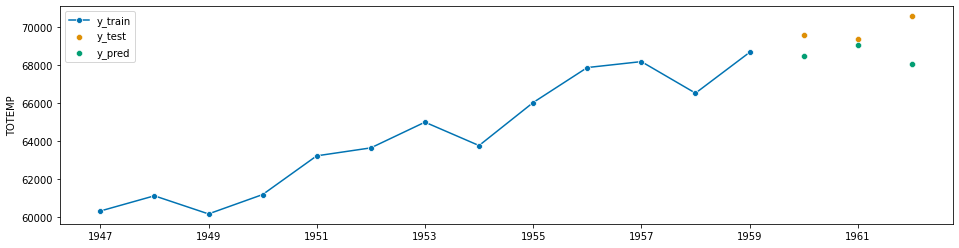

In [63]:
# xxx

# %%time

y, X = load_longley()
display("y:", y.shape)
display("X:", X.shape)

t = Lag([1], index_out="original") * Imputer("nearest")
Xt = t.fit_transform(X)
display("Xt:", Xt.shape)

Xp = pd.concat([X, Xt], axis=1)
display("Xp:", Xp.shape)

fh = ForecastingHorizon([1, 2, 3])
y_train, y_test, X_train, X_test = temporal_train_test_split(y, Xp, fh=fh)
#display(y_train)
regressor = LinearRegression()
# regressor = HistGradientBoostingRegressor()
# regressor = XGBRegressor()
# regressor = LGBMRegressor()
# forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
forecaster = make_reduction(regressor, strategy="recursive")
forecaster.fit(y_train, X_train, fh=fh)
y_pred = forecaster.predict(X=X_test)

display("y_pred:", y_pred)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
# mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

...


---


### Comparison with baselines

Finally, we can compare the best performing gradient boosted etc models against the best baseline method.  The VAR (Vector Auto-Regression) model from the [baselines notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) was the best performing baseline.

The best encoder decoder model, after 5 training epochs, was conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst.  Here I train the same model for 20 epochs.

Some points to note regarding the `plot_forecasts` diagnostic plot:
 * on validation data not test data
 * `plot_forecasts`
   * plot example forecasts with observations and lagged temperatures
      * first row shows examples of best near zero rmse forecasts
      * second row shows examples of worst positive rmse forecasts
      * third row shows examples of worst negative rmse forecasts
      * lagged observations are negative
      * the day of the year the forecast begins in and the rmse value is displayed above each sub-plot

epochs : 20
Epoch 1/5
11759/11759 [==============================] - 13s 1ms/step - loss: 30942466.0000 - mae: 142.3176


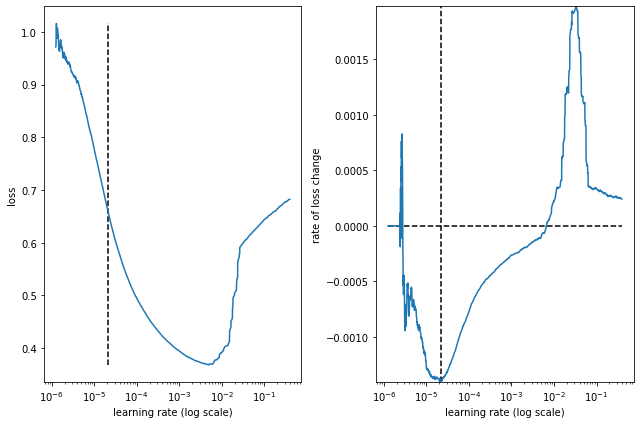

best lr: 2.1549979e-05 

Model: "conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 28, 10, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 10, 64)        512       
                                                                 
 flatten_2 (Flatten)         (None, 17920)             0         
                                                                 
 dense_6 (Dense)             (None, 448)               8028608   
                                                                 
 dense_7 (Dense)             (None, 224)               100576    
                                                                 
 dense_8 (Dense)             (None, 48)                10800     
                                                                 

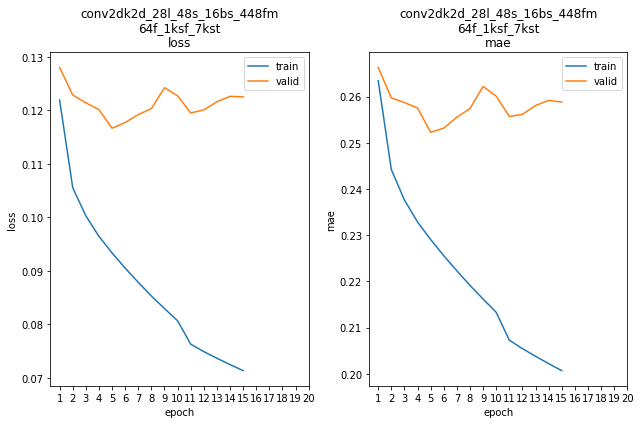

conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst train min loss: 0.071346	mae: 0.200707	epoch: 15
conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst valid min loss: 0.116655	mae: 0.252278	epoch: 5



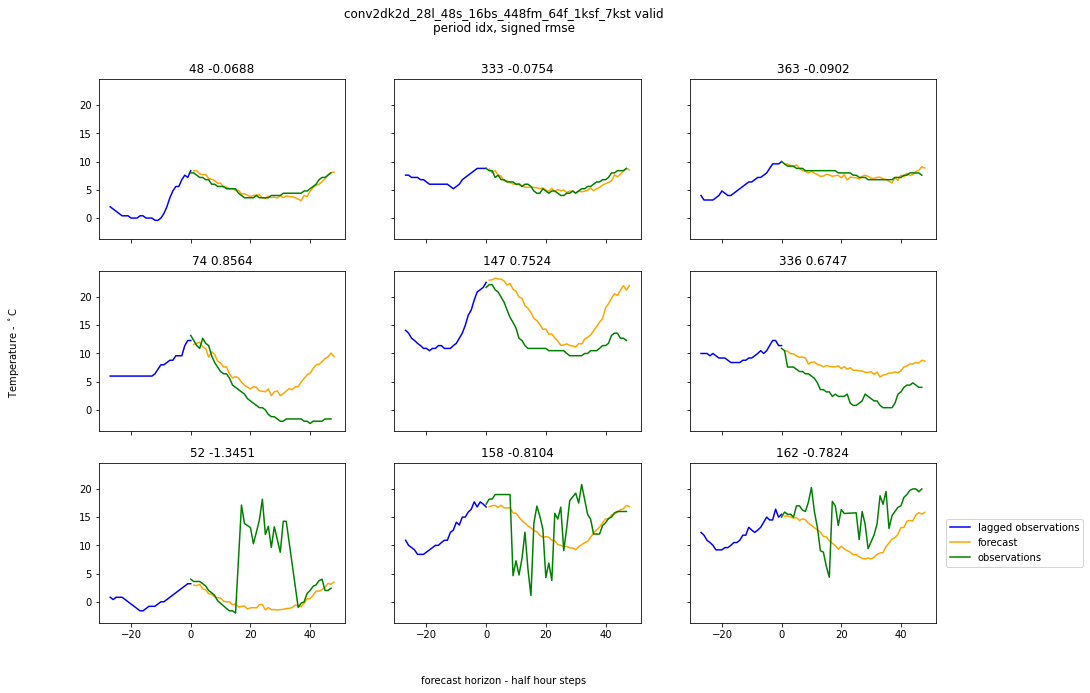

CPU times: user 20min 42s, sys: 3min 50s, total: 24min 32s
Wall time: 20min


In [ ]:
%%time


params = get_default_params('conv2dk2d')
params.update({'feat_maps':  448,
               'filters':     64,
               'lags':        28,
               'ks_feats':     1,
               'ks_time':      7,
               'lrf_params': [0.000001, 10, 32, 5, 100, 25]})
sweep_values = {'epochs': [20]}
models, epochs_model_names = sweep_param(models, params, sweep_values, verbose=True)

model_name = epochs_model_names[0]
plot_forecasts(models, model_name)

Results of the conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst model for 48 steps-ahead forecast after 20 epochs:

| CNN model             | params                         | mse     | mae     |
|-----------------------|--------------------------------|---------|---------|
|Conv2D Kern2D epochs= 5| lags=28, ks_feats=1, ks_time=7 | 0.11686 | 0.25261 |
|Conv2D Kern2D epochs=20| lags=28, ks_feats=1, ks_time=7 | 0.11665 | 0.25228 |

The model stopped training early after 15 epochs.  There was a marginal improvement in mse and mae.  As before, the minimal mse value was acheived at the 4th epoch.  The training plot shows some over-fitting.  Arguably, I should try the next best model but I doubt this will improve results by much.

Diagnostic plot summary:
 * once again, on validation data not test data
 * `plot_forecasts`
   * third row shows three highly suspect looking sets of observations for worst negative rmse forecast examples
   * clearly some remaining problem in the observations

---


Next, I plot the best Conv2D kernel 2D and VAR model rmse and mae values for forecast horizons up to 48 (24 hours, each horizon step is equivalent to 30 minutes).  This plot plus the two others are for forecasts on the previously unused 2019 "test" data.  This is different from the 2018 "validation" data used elsewhere in this notebook.

Some points to note regarding diagnostic plots:
 * once again, on test data not validation data
 * `plot_horizon_metrics`
   * plot rmse and mae values for each individual step-ahead
 * `check_residuals`
   * observations against predictions
   * residuals over time
   * residual distribution
 * `plot_forecasts`
   * see sub-section immediately above for notable points

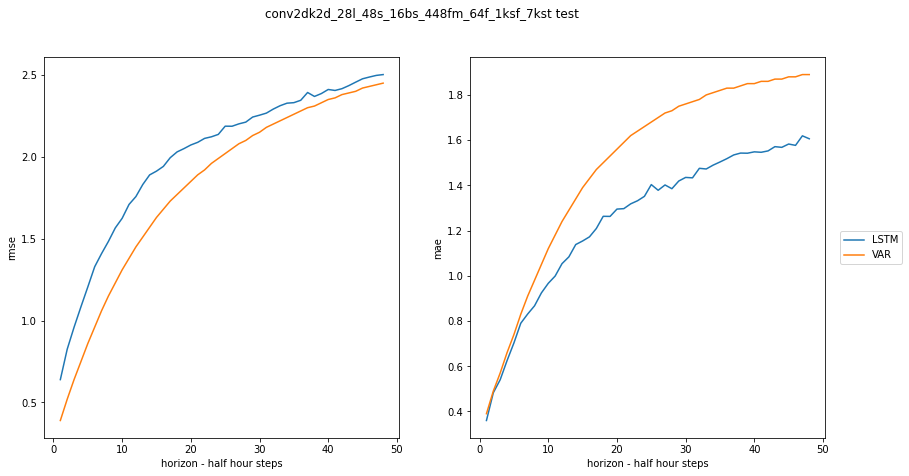

t rmse conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst: 2.057958616855633
t mae conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst:  1.179860027368246


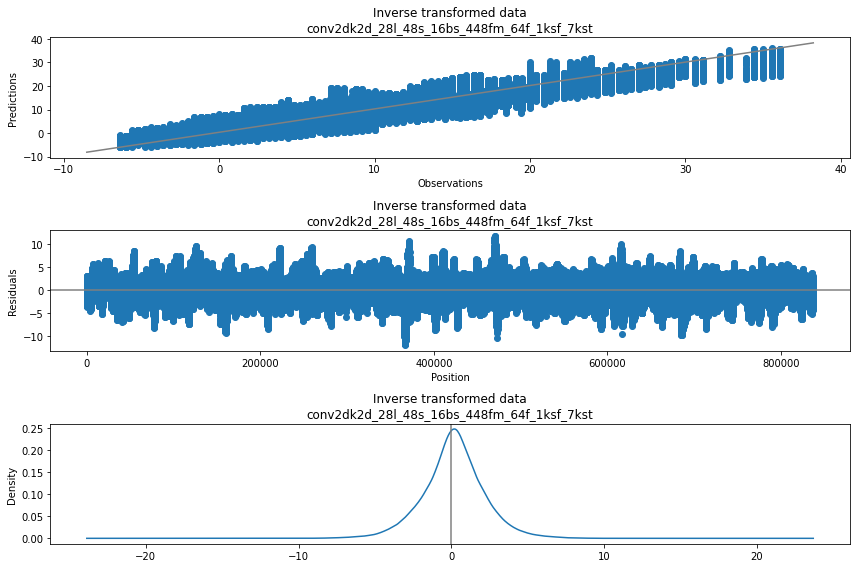

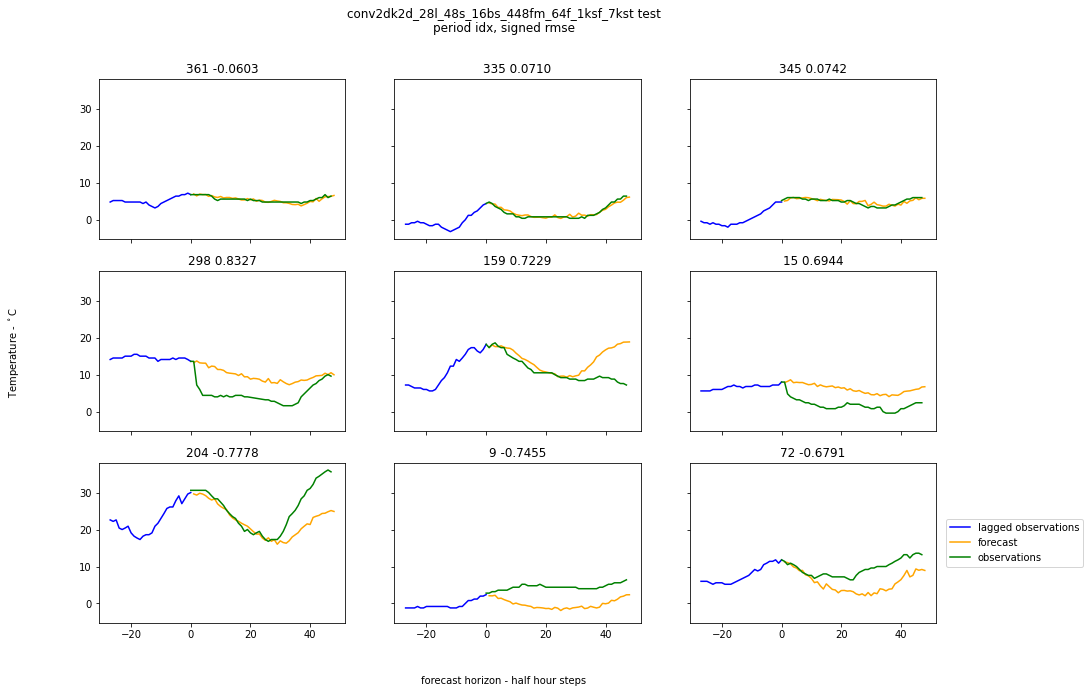

In [ ]:
ds = 'test'
best_mod = 'conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst'

plot_horizon_metrics(models, best_mod, dataset = ds)
check_residuals(models, best_mod, dataset = ds)
plot_forecasts(models, best_mod, dataset = ds)

Broadly speaking, these results are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).


Diagnostic plots summary:
 * once again, these plots use test data not validation data
 * `plot_horizon_metrics`
   * initially, these results look quite contradictory
   * the rmse plot indicates better forecasts for the VAR method (in orange)
   * the mae plot indicates better forecasts for the Conv2D kernel 2D method (in blue, mis-labelled as LSTM)
 * `check_residuals`
   * the observations against predictions plot indicates
     * predictions are too high at cold temperatures (below 0 C) 
     * predictions are too low at hot temperatures (above 25 C)
   * residuals over time
     * no obvious heteroscadicity
     * no obvious periodicity
       * surprising given observations against predictions plot
   * residual distribution appears to be approximately normal (slightly right-skewed)
     * no obvious sign of fat tails
 * `plot_forecasts`
   * notable lack of noisy observations for the large positive and negative rmse examples

The median absolute error (mae) is less sensitive to outliers compared to the root mean squared error (rmse) metric.

Therefore, the rmse and mae plot difference may be due to the presence of outliers. I have maintained from the start that this data set is quite noisy, and attempts to correct these problems may have unintensionally introduced new issues.

Transformed mean values across the 48 step horizon:
 * rmse of 2.05796
 * mae of 1.17986

---


## Conclusion

The best results from the Conv2D kernel 2D are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).

The conclusion is separated into the following sections:
 * What worked
 * What didn't work
 * Future work

What worked:
 * Conv1D followed by
   * LSTM layer
     * simple and reasonably effective set of models
   * 2 Dense layers
     * simple and reasonably effective set of models
 * Multi-head
   * 3 independent Conv1D "heads" with different kernel sizes
     * did not improve on single head Conv1D models
 * Conv2D
   * very high number of parameters
   * single Conv2D layer
     * feature extraction kernel
       * probably the best performing set of models
   * 2 stacked Conv2D layers
     * first feature extraction kernel
     * second temporal extraction kernel
     * reasonable results but didn't improve on single Conv2D layer
 * Inception-style
   * 6 inception modules with residual connections at the 3rd and 6th modules
     * only partially optimised but gave acceptible results
     * may benefit from larger kernel sizes - 2, 8, 16 instead of 2, 4, 8
     * slow to train
 * skopt Bayesian hyperparameter optimisation
   * summary from Conv2D models
     * lags - lower is better
       * some models showed periodicity
       * with secondary minima around 48 and 96 steps
     * feature maps - higher is better
     * filters - higher is better
     * kernel size
       * feature extraction - lower is better
       * temporal extraction - higher is better
   * more optimisation iterations are probably justifiable
   * exact order to optimise parameters in remains unclear
     * feature selection
     * lags?
     * architecture selection
     * learning rate
     * batch size
     * lags?
     * the rest!
     * regularisation parameters _later_ on (best performing models only)

What didn't work:
 * Conv2D
   * single Conv2D layer
     * combined feature-temporal extraction kernel
       * the training plot shows some over-fitting
       * it is recommended to extend training epochs from 5 to 10 to avoid this
 * Dealing with outliers remains problematic
   * further data cleaning would be beneficial
     * particularly labeling the interpolation, imputation etc missing data cases
 * Learning rate finder has issues
   * tuning the start learning rate parameter defeats the purpose of the method
     * this tuning could be replaced with multiple learning rate finder runs
     * using start learning rate parameter increasing in order of magnitude: 1e-5, 1e-4, etc
       * this was performed manually on a per-architecture basis but would benefit from automation
     * choose start learning rate that minimises loss value
     * straight-forward change but will increase running time
 * Mixup
   * the minimal mse value was higher than the Conv2D kernel 2D value without any mixup 
   * perhaps this lack of improvement may be due to the particular Conv2D kernel 2D model overfitting

Future work:
 * Further optimise model and data parameters
   * check robust regression loss functions
     * [Huber loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber)
     * less sensitive to outliers than the squared error loss
   * lags
     * 1-24 plus zero or more of {48, 96, 144, 192, 240, 288, 336}
   * seasonal components
     * one-hot encoded month variables
     * the [Short Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) may be a good option for modeling the daily seasonality
       * it is available in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html)
   * batch mixup
     * probably only time series mixup
   * apply regularisation to best performing model
     * dropout, L2, time series mixup
 * Additional architectures to examine
   * Architectures for integer based variables
       * Temperatures recorded to 0.1 degrees C
       * Recorded as integers (temperature * 10)
       * Other variables?
     * Embeddings
       * ...
     * NLP focused architectures and enhancements
       * Dense output with softmax and use Beam search
       * ...
 * mse and mae horizon plots
   * add confidence intervals

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
seaborn,0.11.2
scikit-learn,1.0.2
pandas,1.3.5
numpy,1.21.6
matplotlib,3.2.2
keras,2.10.0


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.178
BogoMIPS:            4000.35
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!date

Sat Jun 18 14:10:54 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}